# Atividade 9 - Classificador Random Forests
# Relief - Sem Normalização
# Algoritmo RandomForestClassifier

● Semelhante aos anteriores, usando Random Forests

● Parâmetros a serem calibrados: <br>
    – mtry / max_features (o parâmetro mais sensível): raiz (quadrada) de n, n sendo o número de características (testar outros) <br>
    – ntree = 500 (quanto maior melhor, depende do tempo disponível)


## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from pprint import pprint

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing


# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.ensemble import RandomForestClassifier


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


### Características selecionadas pelo Relief na atividade 4

In [3]:
selecionadas_Relief = ['Age',
                       'Num of pregnancies',
                       'Hormonal Contraceptives (years)',
                       'First sexual intercourse',
                       'STDs (number)',
                       'STDs: Number of diagnosis',
                       'Hinselmann',
                       'Schiller',
                       'Citology', 
                       'STDs']

## Pré-Processamento

In [4]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [5]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:

    Para features categoricas --> preenche com o valor mais frequente

No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)


In [6]:
continuous_feat = [ 'Age',
                    'Num of pregnancies',
                    'Hormonal Contraceptives (years)',
                    'First sexual intercourse',
                    'STDs (number)',
                    'STDs: Number of diagnosis'] 

binary_feat = ['Hinselmann',
               'Schiller',
               'Citology', 
               'STDs']

In [7]:
df_imp = df_processed.copy()

In [8]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()

## Stratified Cross- Validation

### Dataset Desbalanceado

In [9]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
        
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    max_features = grid_params.get('max_features')
    n_estimators = grid_params.get('n_estimators')
    max_depth = grid_params.get('max_depth')
    min_samples_split = grid_params.get('min_samples_split')
    #min_samples_leaf = grid_params.get('min_samples_leaf')
    #bootstrap = grid_params.get('bootstrap')
    
    
    # Testa varias max_features
    for mf in max_features:
        print("-> Teste max_features {}".format(mf))
        
        # Testa n_estimators
        for n_estim in n_estimators:
            print("-> Teste n_estimators {}".format(mf))
            
            # Testa max_depth
            for md in max_depth:
                print("-> Teste max_depth {}".format(md))
                
                # Testa min_samples_split
                for min_ss in min_samples_split:
                    print("-> Teste min_samples_split {}".format(min_ss))
                    
#                    # Testa min_samples_leaf
#                    for min_sl in min_samples_leaf:
#                        print("-> Teste min_samples_leaf {}".format(min_sl))
                        
#                         # Testa bootstrap
#                         for bs in bootstrap:
#                             print('\t-> Modelo: max_features ={} | n_estimators {} | max_depth {} | min_samples_split {} | min_samples_leaf {} | bootstrap {}'.format(mf, n_estim, md, min_ss, min_sl, bs))
#                             clf = algoritmo(max_features=mf, n_estimators=n_estim, max_depth=md, min_samples_split=min_ss, min_samples_leaf=min_sl, bootstrap=bs, verbose=0, random_state = random_state)
                    print('\t-> Modelo: max_features ={} | n_estimators {} | max_depth {} | min_samples_split {}'.format(mf, n_estim, md, min_ss))
                    clf = algoritmo(max_features=mf, n_estimators=n_estim, max_depth=md, min_samples_split=min_ss,  verbose=0, random_state = random_state)

                    # Folds
                    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                        fold_number = fold
                        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                        # quantidade de classes dentro da fold
                        #REMOVED

                        # aplica o classificador
                        clf = clf.fit(X_train, y_train)

                        # predict no dataset de treino 
                        y_train_preds = clf.predict(X_train)
                        # predict no dataset de teste
                        y_pred = clf.predict(X_test)


                        # Scores do model (utilizados dados nao-balanceados) - dados de teste
                        recall = recall_score(y_test, y_pred)
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred)
                        scores.append([mf, n_estim, md, min_ss, fold_number, precision, recall, accuracy]) #min_sl, bs, fold_number, precision, recall, accuracy])


    print("Treinamento Finalizado!")
    return np.array(scores)

### Dataset Balanceado

In [10]:
# Cross Validation com dataset BALANCEADO (SMOTETomek)

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')
    
    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    # quantidade original de classes
    count_classes = y.value_counts()
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset (desbalanceado) {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))
   
    # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)

    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    max_features = grid_params.get('max_features')
    n_estimators = grid_params.get('n_estimators')
    max_depth = grid_params.get('max_depth')
    min_samples_split = grid_params.get('min_samples_split')
    #min_samples_leaf = grid_params.get('min_samples_leaf')
    #bootstrap = grid_params.get('bootstrap')
    
    
    # Testa varias max_features
    for mf in max_features:
        print("-> Teste max_features {}".format(mf))
        
        # Testa n_estimators
        for n_estim in n_estimators:
            print("-> Teste n_estimators {}".format(mf))
            
            # Testa max_depth
            for md in max_depth:
                print("-> Teste max_depth {}".format(md))
                
                # Testa min_samples_split
                for min_ss in min_samples_split:
                    print("-> Teste min_samples_split {}".format(min_ss))
                    
#                    # Testa min_samples_leaf
#                    for min_sl in min_samples_leaf:
#                        print("-> Teste min_samples_leaf {}".format(min_sl))

#                         # Testa bootstrap
#                         for bs in bootstrap:
#                             print('\t-> Modelo: max_features ={} | n_estimators {} | max_depth {} | min_samples_split {} | min_samples_leaf {} | bootstrap {}'.format(mf, n_estim, md, min_ss, min_sl, bs))
#                             clf = algoritmo(max_features=mf, n_estimators=n_estim, max_depth=md, min_samples_split=min_ss, min_samples_leaf=min_sl, bootstrap=bs,verbose=0, random_state = random_state)
                    print('\t-> Modelo: max_features ={} | n_estimators {} | max_depth {} | min_samples_split {}'.format(mf, n_estim, md, min_ss))
                    clf = algoritmo(max_features=mf, n_estimators=n_estim,  max_depth=md, min_samples_split=min_ss, verbose=0, random_state = random_state)

                    # Folds
                    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                        fold_number = fold
                        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                        # Normaliza MinMax para aplicar Smote
                        X_train_normalized = minmax_scale.fit_transform(X_train)
                        X_train_normalized = pd.DataFrame(X_train_normalized, columns = X.columns.tolist())

                        # SMOTETomek (apenas os dados de treino)
        #                    print('\tBalanceando dados de treino fold {}...'.format(fold_number))
                        X_train, y_train = cc.fit_resample(X_train_normalized, y_train)

                        # Retorna para valores não normalizados
                        X_train = pd.DataFrame(minmax_scale.inverse_transform(X_train), columns = X.columns.tolist())
        #                    print folds balanceados
                        #REMOVED

                        # quantidade de classes dentro da fold
                        #REMOVED

                        # aplica o classificador
                        clf = clf.fit(X_train, y_train)

                        # predict no dataset de treino 
                        y_train_preds = clf.predict(X_train)
                        # predict no dataset de teste
                        y_pred = clf.predict(X_test)


                        # Scores do model (utilizados dados nao-balanceados) - dados de teste
                        recall = recall_score(y_test, y_pred)
                        accuracy = accuracy_score(y_test, y_pred)
                        precision = precision_score(y_test, y_pred)
                        scores.append([mf, n_estim, md, min_ss, fold_number, precision, recall, accuracy]) #min_sl,  bs, fold_number, precision, recall, accuracy])

    print("Treinamento Finalizado!")
    return np.array(scores)

## Grid de Parametros para teste

In [11]:
grid_params_all = {'max_features': ["sqrt", "log2", None], # Number of features to consider at every split
                   'n_estimators' : [int(x) for x in np.linspace(start = 10, stop = 200, num = 5)], # Number of trees in random forest # defautl = 100 
                   'max_depth':  [int(x) for x in range(1, 20, 4)] + [None], # Maximum number of levels in tree
                   'min_samples_split': [2, 3, 4, 5], # Minimum number of samples required to split a node
                   #'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
                   #'bootstrap': [True, False] # Method of selecting samples for training each tree
              }

pprint(grid_params_all)

{'max_depth': [1, 5, 9, 13, 17, None],
 'max_features': ['sqrt', 'log2', None],
 'min_samples_split': [2, 3, 4, 5],
 'n_estimators': [10, 57, 105, 152, 200]}


## Calculando Precisão, Revocação e Acurácia

### Algortimo-> RandomForestClassifier

In [12]:
df_selecionado = df_imp[selecionadas_Relief]
df_selecionado = df_selecionado.join(df_imp['Biopsy'])

df_selecionado.head()

,Age,Num of pregnancies,Hormonal Contraceptives (years),First sexual intercourse,STDs (number),STDs: Number of diagnosis,Hinselmann,Schiller,Citology,STDs,Biopsy
0,18.0,1.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,15.0,1.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,34.0,1.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,52.0,4.0,3.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,46.0,4.0,15.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Dataset Desbalanceado

In [13]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_selecionado, k, RandomForestClassifier, random_state, grid_params_all,  shuffle=False, shrinking=True))
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'max_features', 1: 'n_estimators',  2: 'max_depth', 3: 'min_samples_split', 4:'Fold', 5: 'Precision', 6: 'Recall', 7: 'Accuracy'}) 

scores_unbalanced['Algorimto'] = 'RandomForestClassifier'

#float_cols = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'Fold', 'Precision', 'Recall', 'Accuracy']
float_cols = ['n_estimators',  'max_depth', 'min_samples_split',  'Fold', 'Precision', 'Recall', 'Accuracy']
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')


#string_cols = ['max_features', 'bootstrap']
string_cols = ['max_features']
scores_unbalanced[string_cols] = scores_unbalanced[string_cols].astype(str)
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste max_features sqrt
-> Teste n_estimators sqrt
-> Teste max_depth 1
-> Teste min_samples_split 2
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 1 | min_samples_split 2
-> Teste min_samples_split 3
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 1 | min_samples_split 3
-> Teste min_samples_split 4
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 1 | min_samples_split 4
-> Teste min_samples_split 5
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 1 | min_samples_split 5
-> Teste max_depth 5
-> Teste min_samples_split 2
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 5 | min_samples_split 2
-> Teste min_samples_split 3
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 5 | min_samples_split 3
-> Teste min_samples_split 4
	-> Modelo: max_fe

In [14]:
display(scores_unbalanced.head())

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Relief-Sem_Normalizacao_RandomForestsClassifier.xlsx', encoding='utf-8-sig')

,max_features,n_estimators,max_depth,min_samples_split,Fold,Precision,Recall,Accuracy,Algorimto
0,sqrt,10,1.0,2,1,0.0,0.0,0.941860,RandomForestClassifier
1,sqrt,10,1.0,2,2,0.0,0.0,0.941860,RandomForestClassifier
2,sqrt,10,1.0,2,3,0.0,0.0,0.941860,RandomForestClassifier
3,sqrt,10,1.0,2,4,0.0,0.0,0.930233,RandomForestClassifier
4,sqrt,10,1.0,2,5,0.0,0.0,0.930233,RandomForestClassifier


### Dataset Balanceado

In [15]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_selecionado, k, RandomForestClassifier, random_state, grid_params_all,  shuffle=False, shrinking=True))
scores_balanced = scores_balanced.rename(columns = {0: 'max_features', 1: 'n_estimators',  2: 'max_depth', 3: 'min_samples_split', 4:'Fold', 5: 'Precision', 6: 'Recall', 7: 'Accuracy'}) 


scores_balanced['Algorimto'] = 'RandomForestClassifier'


#float_cols = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'Fold', 'Precision', 'Recall', 'Accuracy']
float_cols = ['n_estimators',  'max_depth', 'min_samples_split', 'Fold', 'Precision', 'Recall', 'Accuracy']
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')


#string_cols = ['max_features', 'bootstrap']
string_cols = ['max_features']
scores_balanced[string_cols] = scores_balanced[string_cols].astype(str)
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
------
k = 10, Dataset (desbalanceado) 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste max_features sqrt
-> Teste n_estimators sqrt
-> Teste max_depth 1
-> Teste min_samples_split 2
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 1 | min_samples_split 2
-> Teste min_samples_split 3
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 1 | min_samples_split 3
-> Teste min_samples_split 4
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 1 | min_samples_split 4
-> Teste min_samples_split 5
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 1 | min_samples_split 5
-> Teste max_depth 5
-> Teste min_samples_split 2
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 5 | min_samples_split 2
-> Teste min_samples_split 3
	-> Modelo: max_features =sqrt | n_estimators 10 | max_depth 5 | min_samples_split 3
-> Teste min_samples_split 4
	-

In [16]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Relief-Sem_Normalizacao_RandomForestsClassifier.xlsx', encoding='utf-8-sig')

,max_features,n_estimators,max_depth,min_samples_split,Fold,Precision,Recall,Accuracy,Algorimto
0,sqrt,10,1.0,2,1,0.555556,1.000000,0.953488,RandomForestClassifier
1,sqrt,10,1.0,2,2,0.625000,1.000000,0.965116,RandomForestClassifier
2,sqrt,10,1.0,2,3,0.500000,0.800000,0.941860,RandomForestClassifier
3,sqrt,10,1.0,2,4,0.857143,1.000000,0.988372,RandomForestClassifier
4,sqrt,10,1.0,2,5,0.500000,0.666667,0.930233,RandomForestClassifier


## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [17]:
mean_unbalanced = scores_unbalanced.groupby(['max_features', 'n_estimators', 'max_depth', 'min_samples_split']).mean().drop('Fold', axis = 1)
mean_unbalanced

Precision    Recall  Accuracy
max_features n_estimators max_depth min_samples_split                               
None         10           1.0       2                   0.683135  0.876667  0.961546
                                    3                   0.683135  0.876667  0.961546
                                    4                   0.683135  0.876667  0.961546
                                    5                   0.683135  0.876667  0.961546
                          5.0       2                   0.643254  0.736667  0.955718
                                    3                   0.676587  0.736667  0.958071
                                    4                   0.707937  0.716667  0.960397
                                    5                   0.707937  0.716667  0.960397
                          9.0       2                   0.661190  0.643333  0.953379
                                    3                   0.703571  0.656667  0.955732
                                    4                   0.757381  0.676667  0.960383
                                    5                   0.737381  0.676667  0.959220
                          13.0      2                   0.658810  0.626667  0.952216
                                    3                   0.701190  0.640000  0.954569
                                    4                   0.757381  0.676667  0.960383
                                    5                   0.737381  0.676667  0.959220
                          17.0      2                   0.658810  0.626667  0.952216
                                    3                   0.701190  0.640000  0.954569
                                    4                   0.757381  0.676667  0.960383
                                    5                   0.737381  0.676667  0.959220
             57           1.0       2                   0.683135  0.876667  0.961546
                                    3                   0.683135  0.876667  0.961546
                                    4                   0.683135  0.876667  0.961546
                                    5                   0.683135  0.876667  0.961546
                          5.0       2                   0.611508  0.696667  0.951067
                                    3                   0.660556  0.696667  0.954583
                                    4                   0.686746  0.680000  0.955746
                                    5                   0.673889  0.696667  0.955746
                          9.0       2                   0.594048  0.643333  0.947565
                                    3                   0.627381  0.643333  0.949918
                                    4                   0.677857  0.643333  0.953406
                                    5                   0.677857  0.643333  0.953406
                          13.0      2                   0.594048  0.643333  0.947565
                                    3                   0.617857  0.623333  0.947579
                                    4                   0.677857  0.643333  0.953406
                                    5                   0.677857  0.643333  0.953406
                          17.0      2                   0.594048  0.643333  0.947565
                                    3                   0.617857  0.623333  0.947579
                                    4                   0.677857  0.643333  0.953406
                                    5                   0.677857  0.643333  0.953406
             105          1.0       2                   0.683135  0.876667  0.961546
                                    3                   0.683135  0.876667  0.961546
                                    4                   0.683135  0.876667  0.961546
                                    5                   0.683135  0.876667  0.961546
                          5.0       2                   0.611508  0.696667  0.951067
                                    3                   0.69

In [18]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

Precision    Recall  Accuracy
max_features n_estimators max_depth min_samples_split                               
sqrt         200          5.0       4                   0.752976  0.756667  0.965048
log2         200          5.0       4                   0.752976  0.756667  0.965048
             57           9.0       4                   0.733452  0.773333  0.965048
sqrt         57           9.0       4                   0.733452  0.773333  0.965048
                          13.0      3                   0.730119  0.740000  0.962722

('log2', 57, 9.0, 4)

### Dataset Balanceado

In [19]:
mean_balanced = scores_balanced.groupby(['max_features', 'n_estimators', 'max_depth', 'min_samples_split']).mean().drop('Fold', axis = 1)
mean_balanced

Precision    Recall  Accuracy
max_features n_estimators max_depth min_samples_split                               
None         10           1.0       2                   0.683135  0.876667  0.961546
                                    3                   0.683135  0.876667  0.961546
                                    4                   0.683135  0.876667  0.961546
                                    5                   0.683135  0.876667  0.961546
                          5.0       2                   0.641962  0.803333  0.955705
                                    3                   0.619105  0.803333  0.953352
                                    4                   0.619105  0.803333  0.953352
                                    5                   0.653867  0.803333  0.956867
                          9.0       2                   0.576486  0.743333  0.947538
                                    3                   0.573153  0.726667  0.946361
                                    4                   0.607597  0.743333  0.951012
                                    5                   0.619264  0.743333  0.952202
                          13.0      2                   0.571310  0.690000  0.946361
                                    3                   0.586764  0.743333  0.948687
                                    4                   0.607597  0.743333  0.951012
                                    5                   0.619264  0.743333  0.952202
                          17.0      2                   0.571310  0.690000  0.946361
                                    3                   0.586764  0.743333  0.948687
                                    4                   0.607597  0.743333  0.951012
                                    5                   0.619264  0.743333  0.952202
             57           1.0       2                   0.683135  0.876667  0.961546
                                    3                   0.683135  0.876667  0.961546
                                    4                   0.683135  0.876667  0.961546
                                    5                   0.683135  0.876667  0.961546
                          5.0       2                   0.593391  0.803333  0.948659
                                    3                   0.626248  0.803333  0.953338
                                    4                   0.638153  0.803333  0.954501
                                    5                   0.638153  0.803333  0.954501
                          9.0       2                   0.542478  0.710000  0.942859
                                    3                   0.549621  0.710000  0.944022
                                    4                   0.558550  0.710000  0.945185
                                    5                   0.566407  0.710000  0.945185
                          13.0      2                   0.542478  0.710000  0.942859
                                    3                   0.551407  0.710000  0.944022
                                    4                   0.541407  0.690000  0.942859
                                    5                   0.558074  0.690000  0.944022
                          17.0      2                   0.542478  0.710000  0.942859
                                    3                   0.551407  0.710000  0.944022
                                    4                   0.541407  0.690000  0.942859
                                    5                   0.558074  0.690000  0.944022
             105          1.0       2                   0.683135  0.876667  0.961546
                                    3                   0.683135  0.876667  0.961546
                                    4                   0.683135  0.876667  0.961546
                                    5                   0.683135  0.876667  0.961546
                          5.0       2                   0.603391  0.803333  0.951012
                                    3                   0.61

In [20]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

,,,,Precision,Recall,Accuracy
max_features,n_estimators,max_depth,min_samples_split,,,
sqrt,10,9.0,5,0.707778,0.840000,0.963885
log2,10,9.0,5,0.707778,0.840000,0.963885
sqrt,10,5.0,2,0.696508,0.856667,0.963858
log2,10,5.0,2,0.696508,0.856667,0.963858
sqrt,10,5.0,4,0.685159,0.836667,0.962709


('log2', 10, 9.0, 5)

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [21]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['max_features'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['n_estimators'] == max_alpha_unbalanced[1]) &
                                                             (scores_unbalanced['max_depth'] == max_alpha_unbalanced[2]) &
                                                             (scores_unbalanced['min_samples_split'] == max_alpha_unbalanced[3])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.965, IC = [0.950, 0.980]
Recall: Média = 0.773, IC = [0.649, 0.898]
Precisão: Média = 0.733, IC = [0.602, 0.865]


### Dataset Balanceado

In [22]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['max_features'] == max_alpha_balanced[0]) &
                                                       (scores_balanced['n_estimators'] == max_alpha_balanced[1]) &
                                                       (scores_balanced['max_depth'] == max_alpha_balanced[2]) &
                                                       (scores_balanced['min_samples_split'] == max_alpha_balanced[3])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.964, IC = [0.952, 0.976]
Recall: Média = 0.840, IC = [0.770, 0.910]
Precisão: Média = 0.708, IC = [0.593, 0.823]


## Gráfico

In [23]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(152.00000000000003, 0.5, '')]

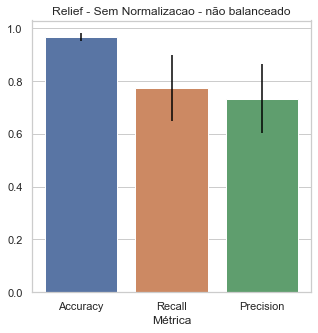

In [24]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('Relief - Sem Normalizacao - não balanceado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('Relief-Sem_Normalizacao-nao_balanceado-RandomForestClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(152.00000000000003, 0.5, '')]

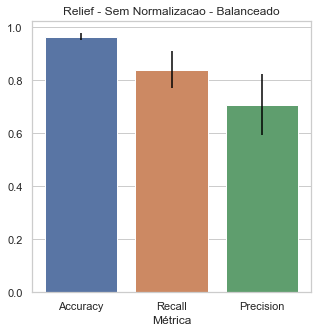

In [25]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('Relief - Sem Normalizacao - Balanceado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('Relief-Sem_Normalizacao-balanceado-RandomForestClassifier', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [26]:
path_to_save = '../../model_results/'
score_min_unbalanced = pd.DataFrame([acc_min_unbalanced, rec_min_unbalanced, pre_min_unbalanced]).rename(columns = {0: 'Score'})
score_max_unbalanced =  pd.DataFrame([acc_max_unbalanced, rec_max_unbalanced, pre_max_unbalanced]).rename(columns = {0: 'Score'})
score_min_balanced = pd.DataFrame([acc_min_balanced, rec_min_balanced, pre_min_balanced]).rename(columns = {0: 'Score'})
score_max_balanced =  pd.DataFrame([acc_max_balanced, rec_max_balanced, pre_max_balanced]).rename(columns = {0: 'Score'})

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    'RandomForestClassifier',
    '9',
    'ReliefF Desbalanceado - Nao Normalizado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_unbalanced[metrica],score_min_unbalanced.loc[metrica]['Score'], score_max_unbalanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    'RandomForestClassifier',
    '9',
    'ReliefF Balanceado - Nao Normalizado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value'],
    '[{:.3f}, {:.3f}, {:.3f}]'.format(mean_balanced[metrica],score_min_balanced.loc[metrica]['Score'], score_max_balanced.loc[metrica]['Score'])
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0:'Algoritmo' , 1: 'Atividade', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor', 6: 'Intervalo_Confianca'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

,Algoritmo,Atividade,Condicao,Melhores_Params,Metrica,Valor,Intervalo_Confianca
0,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Accuracy,0.896129,"[0.896, 0.857, 0.935]"
1,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Recall,0.02,"[0.020, -0.025, 0.065]"
2,SVC,7,Branch and Bound Balanceado - Nao Normalizado,"('sigmoid', 1, '0.0201')",Precision,0.00666667,"[0.007, -0.008, 0.022]"
3,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Accuracy,0.690109,"[0.690, 0.473, 0.907]"
4,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Recall,0.216667,"[0.217, -0.049, 0.482]"
5,Naive Bayes,6,Branch and Bound Balanceado - Nao Normalizado,0.3,Precision,0.0492712,"[0.049, -0.024, 0.123]"
6,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Accuracy,0.822886,"[0.823, 0.784, 0.862]"
7,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Recall,0.153333,"[0.153, 0.034, 0.272]"
8,SVC,7,Branch and Bound Balanceado - Normalizado,"('rbf', 1000, '0.9401')",Precision,0.0906421,"[0.091, 0.013, 0.169]"
9,Naive Bayes,6,Branch and Bound Balanceado - Normalizado,0.1,Accuracy,0.512845,"[0.513, 0.416, 0.610]"


Resultados salvos com sucesso
